In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import warnings
from scipy import stats
from sklearn import preprocessing, metrics, svm
from sklearn.linear_model import LogisticRegression
import os
warnings.filterwarnings('ignore')
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows',150)
pd.set_option('display.width', 1000)

# Useful classes to have easier access to data features
class ColumnsInput:
    barcode = 'ddc_barcode'
    ipcode = 'ddc_ipcode'
    machine = 'ddc_mch_code'
    machine_side = 'ddc_mch_side'
    event = 'ddc_ev_subcode'
    time = 'ddc_ev_timestamp'
    
    
class ColumnsOutput:
    c_machine = 'c_machine' 
    event_delta_time = 'event_delta_time'
    day = 'y-m-day'
    hour = 'y-m-d-hour'
    month = 'month'
    status = 'status'

file_list = os.listdir('../Data/data_per_machine/2022/raw/')
print(file_list)
mach_name = [file.replace('.csv','') for file in file_list]
print(mach_name, len(mach_name))

['C403.csv', 'C103.csv', '1506.csv', 'C305.csv', 'C105.csv', 'C211.csv', '1306.csv', 'C603.csv', 'C210.csv', 'C605.csv', '1302.csv', 'C312.csv', '1501.csv', '1206.csv', 'C102.csv', 'C404.csv', '1402.csv', 'C307.csv', 'C207.csv', '1304.csv', '1406.csv', 'C511.csv', '1305.csv', 'C507.csv', '1301.csv', 'C608.csv', 'C612.csv', 'C209.csv', '1502.csv', '1403.csv', '1303.csv', 'C410.csv', 'C502.csv', 'C501.csv', '1507.csv', 'C407.csv', 'C412.csv', '1205.csv', 'C508.csv', '1404.csv', 'C303.csv', 'C111.csv', 'C610.csv', '1307.csv', 'C110.csv', 'C106.csv', 'C308.csv', 'C309.csv', 'C503.csv', '1407.csv', 'C202.csv', 'C509.csv', '1401.csv', 'C104.csv', 'C406.csv', '1203.csv', 'C601.csv', '1505.csv', 'C408.csv', 'C205.csv', 'C504.csv', 'C602.csv', 'C203.csv', 'C204.csv', 'C607.csv', 'C510.csv', 'C301.csv', 'C206.csv', 'C310.csv', 'C311.csv', 'C109.csv', '1201.csv', 'C411.csv', 'C512.csv', 'C101.csv', 'C405.csv', 'C401.csv', 'C505.csv', 'C201.csv', 'C409.csv', 'C302.csv', 'C606.csv', 'C609.csv', '15

In [38]:
def general_plot(x_, y_, x_bounds = None, y_bounds = None, title = None, x_title = None, y_title = None):
    fig, ax = plt.subplots(figsize=(15, 4))

    plt.xticks(rotation=90)
    plt.grid(True)
    
    if title is not None:
        plt.title(title)
    
    if x_title is not None:    
        plt.xlabel(x_title)
        
    if y_title is not None:    
        plt.ylabel(y_title)
    
    if (x_bounds is not None):
        plt.xlim(x_bounds)
               
    if (y_bounds is not None):
        plt.ylim(y_bounds)
    ax.plot(x_,y_, 'bo')
    
    plt.show()

# Set the machine to analyse with the index


In [39]:
mach_index = 5

In [40]:
df = pd.read_csv('../Data/data_per_machine/2022/raw/' + file_list[mach_index])
df[ColumnsInput.time] = pd.to_datetime(df[ColumnsInput.time])
current_machine = mach_name[mach_index]
days = df[ColumnsOutput.day].unique()
df[ColumnsOutput.hour] = df[ColumnsInput.time].dt.strftime('%y-%m-%d-%H')
print(df.head())
print(df.info())


   Unnamed: 0  ddc_barcode  ddc_ipcode ddc_mch_code ddc_mch_side        ddc_ev_subcode    ddc_ev_timestamp  c_machine  month   y-m-day   y-m-d-hour
0        1464   9439703146       42579         C211            R        CURING_ON_STOP 2022-10-10 00:02:50       True     10  22-10-10  22-10-10-00
1        1465   9439703146       42579         C211            R      CURING_OFF_START 2022-10-10 00:02:50       True     10  22-10-10  22-10-10-00
2        1466   9439703147       42579         C211            L        CURING_ON_STOP 2022-10-10 00:02:50       True     10  22-10-10  22-10-10-00
3        1467   9439703147       42579         C211            L      CURING_OFF_START 2022-10-10 00:02:50       True     10  22-10-10  22-10-10-00
4        1480   9439703146       42579         C211            R  OP_SQUEEZE_OFF_START 2022-10-10 00:02:52       True     10  22-10-10  22-10-10-00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266263 entries, 0 to 266262
Data columns (total 11 columns):
 

In [41]:
working_time_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day['work_time'] = (working_time_per_day['max'] - working_time_per_day['min']).dt.total_seconds()
print(working_time_per_day.shape)
print(working_time_per_day.head())

working_time_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day_per_arm['work_time'] = (working_time_per_day_per_arm['max'] - working_time_per_day_per_arm['min']).dt.total_seconds()
print(working_time_per_day_per_arm.head())
working_time_per_day_per_right = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)
working_time_per_day_per_left = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
working_time_per_day_per_right.shape


(46, 4)
    y-m-day                 min                 max  work_time
0  22-10-10 2022-10-10 00:02:50 2022-10-10 23:51:31    85721.0
1  22-10-11 2022-10-11 00:07:29 2022-10-11 17:37:31    63002.0
2  22-10-12 2022-10-12 00:07:39 2022-10-12 23:59:34    85915.0
3  22-10-13 2022-10-13 00:00:23 2022-10-13 16:04:07    57824.0
4  22-10-16 2022-10-16 10:10:19 2022-10-16 13:30:40    12021.0
    y-m-day ddc_mch_side                 min                 max  work_time
0  22-10-10            L 2022-10-10 00:02:50 2022-10-10 23:51:31    85721.0
1  22-10-10            R 2022-10-10 00:02:50 2022-10-10 23:51:31    85721.0
2  22-10-11            L 2022-10-11 00:07:29 2022-10-11 17:37:28    62999.0
3  22-10-11            R 2022-10-11 00:07:29 2022-10-11 17:37:31    63002.0
4  22-10-12            L 2022-10-12 00:07:39 2022-10-12 23:59:34    85915.0


(46, 5)

In [42]:
mach_tyre_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.barcode].nunique().dropna().reset_index()
print(mach_tyre_per_day.shape)
mach_tyre_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.barcode].nunique().reset_index()
print(mach_tyre_per_day_per_arm.shape)
mach_tyre_per_day_per_left = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
mach_tyre_per_day_per_right = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)



(46, 2)
(92, 3)


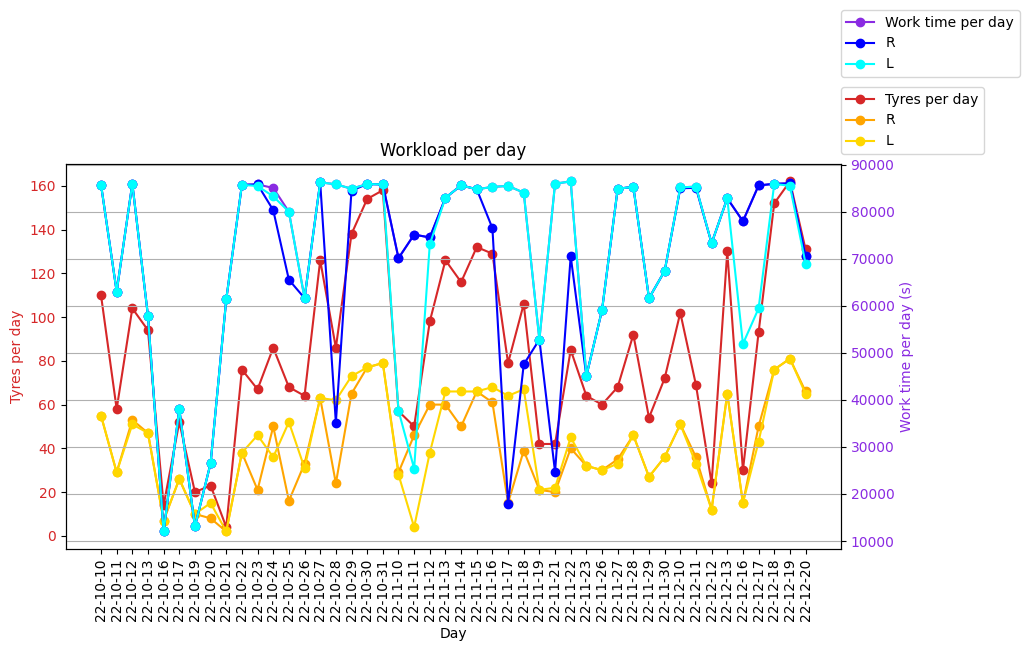

In [43]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1.2), loc=2, borderaxespad=0.)

color = 'blueviolet'
ax_right = ax_left.twinx()
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1.4), loc=2, borderaxespad=0.)
plt.title('Workload per day')
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()


## Dividing the plots

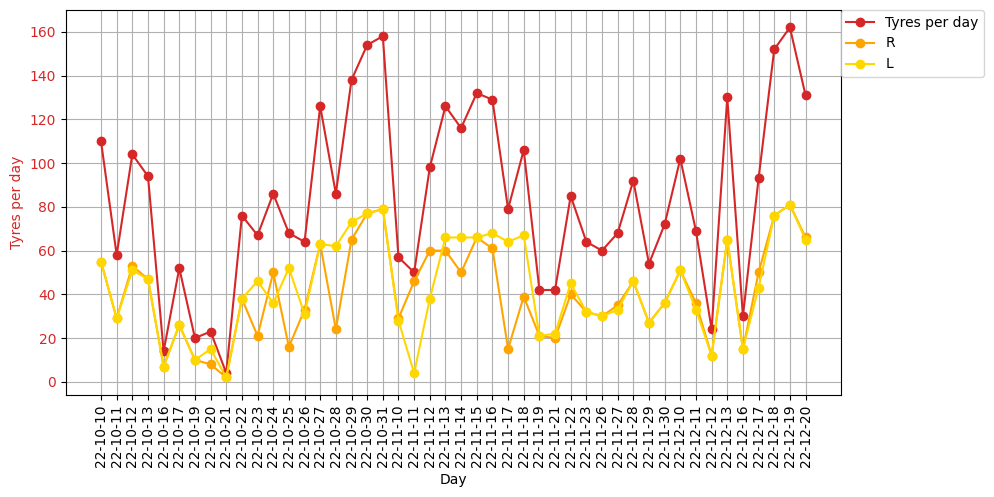

In [44]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

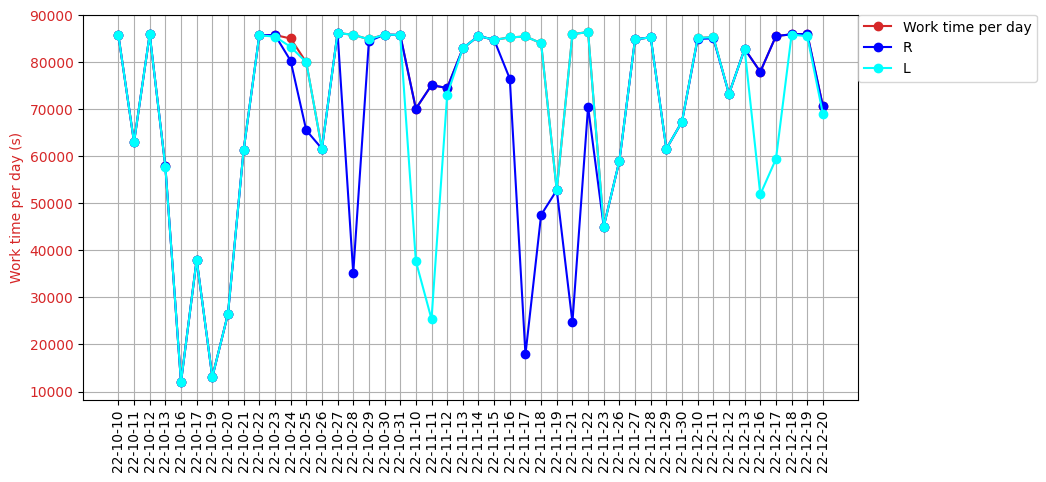

In [45]:
x = working_time_per_day[ColumnsOutput.day]
figure, ax_right = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

In [46]:
# mean_n_tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode].mean()
# for i in range(len(mach_tyre_per_day)):
#     if mach_tyre_per_day[ColumnsInput.barcode][i] <=  mean_n_tyre_per_day:
#         print('Machine '+str(current_machine)+ " in day " +mach_tyre_per_day[ColumnsOutput.day][i] +' is underperforming')
#         df.drop(df[df[ColumnsOutput.day] == mach_tyre_per_day[ColumnsOutput.day][i]].index, inplace = True)

In [47]:
label_cycle_status = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status[ColumnsOutput.status] = False
print(label_cycle_status.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status[ColumnsOutput.status] = label_cycle_status.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status.value_counts(ColumnsOutput.status)
label_cycle_status.shape
label_cycle_status_ = label_cycle_status.copy()
label_for_check_time_loss = label_cycle_status_

Index(['y-m-day', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')


<Axes: xlabel='status'>

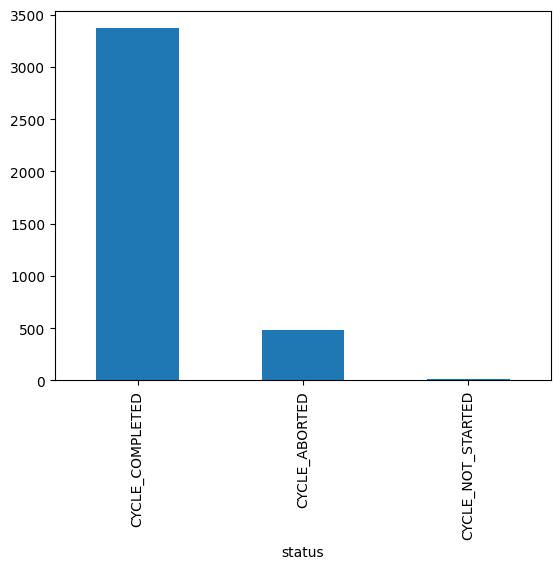

In [48]:
label_cycle_status_[ColumnsOutput.status].value_counts().plot(kind='bar')    

<Axes: xlabel='status'>

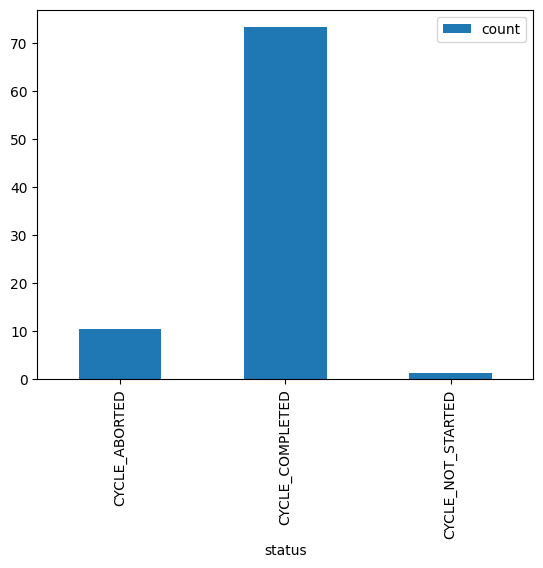

In [49]:
cycle_statuses_per_day = label_cycle_status_.groupby([ColumnsOutput.day])[ColumnsOutput.status].value_counts().reset_index()
cycle_statuses_per_day_mean = cycle_statuses_per_day.groupby([ColumnsOutput.status])['count'].mean().reset_index()
cycle_statuses_per_day_mean.plot(kind='bar', x=ColumnsOutput.status, y='count')

In [50]:
cycle_statuses_per_day = label_cycle_status.groupby([ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day[status] = 0
print(len(cycle_statuses_per_day))
print(cycle_statuses_per_day.head())
statuses_per_day = []
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

46
status   y-m-day  CYCLE_ABORTED  CYCLE_COMPLETED  CYCLE_NOT_STARTED
0       22-10-10             50               59                  1
1       22-10-11             21               36                  1
2       22-10-12             35               69                  0
3       22-10-13             26               68                  0
4       22-10-16              4               10                  0
(46, 2)
Index(['y-m-day', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(46, 2)
Index(['y-m-day', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(46, 2)
Index(['y-m-day', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')




3


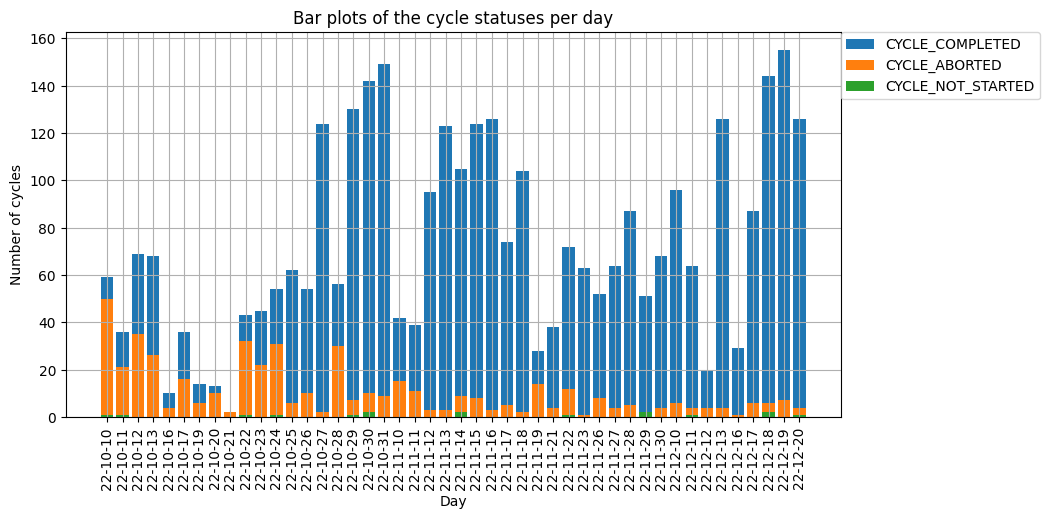

In [51]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day))
for i in range(len(statuses_per_day)):
    ax.bar(statuses_per_day[i][ColumnsOutput.day], statuses_per_day[i]['count'], label = status_names[i])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)
plt.show()


### Checking right and left sides as well

In [52]:
# label_cycle_status_right = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'R']
# label_cycle_status_left = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'L']
# cycle_statuses_per_day_left = label_cycle_status_left.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_left = []
# for status in cycle_statuses_per_day_left[ColumnsOutput.status].unique():
#     statuses_per_day_left.append(cycle_statuses_per_day_left[cycle_statuses_per_day_left[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_left:
#     print(i.shape)
#     print('\n')
# cycle_statuses_per_day_right = label_cycle_status_right.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_right = []
# for status in cycle_statuses_per_day_right[ColumnsOutput.status].unique():
#     statuses_per_day_right.append(cycle_statuses_per_day_right[cycle_statuses_per_day_right[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_right:
#     print(i.shape)
#     print('\n')


# cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
# cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()
# cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
# for status in status_names:
#     if status not in cycle_statuses_per_day_left.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_left[status] = 0
#     if status not in cycle_statuses_per_day_right.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_right[status] = 0
# print(cycle_statuses_per_day_right)




In [53]:
cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day_left.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_left[status] = 0
    if status not in cycle_statuses_per_day_right.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_right[status] = 0
statuses_per_day_left = []
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_left:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')
statuses_per_day_right = []    
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_right:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

(46, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(46, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(46, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(46, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(46, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(46, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_NOT_

3


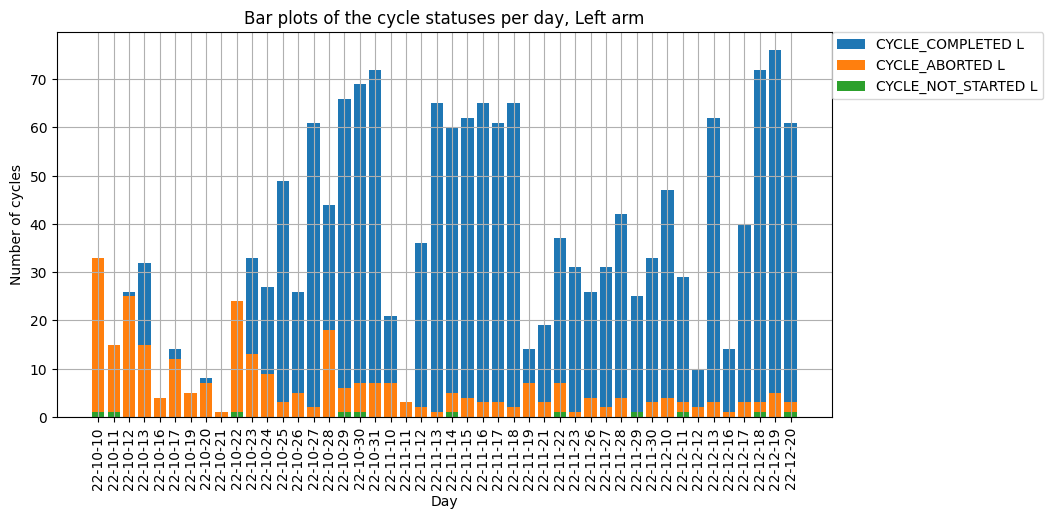

In [54]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_left[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day_left))
plt.bar(statuses_per_day_left[0][ColumnsOutput.day], statuses_per_day_left[0]['count'], label = status_names[0] +' L')
plt.bar(statuses_per_day_left[1][ColumnsOutput.day], statuses_per_day_left[1]['count'], label = status_names[1] + ' L')
plt.bar(statuses_per_day_left[2][ColumnsOutput.day], statuses_per_day_left[2]['count'], label = status_names[2] + ' L')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Left arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

46


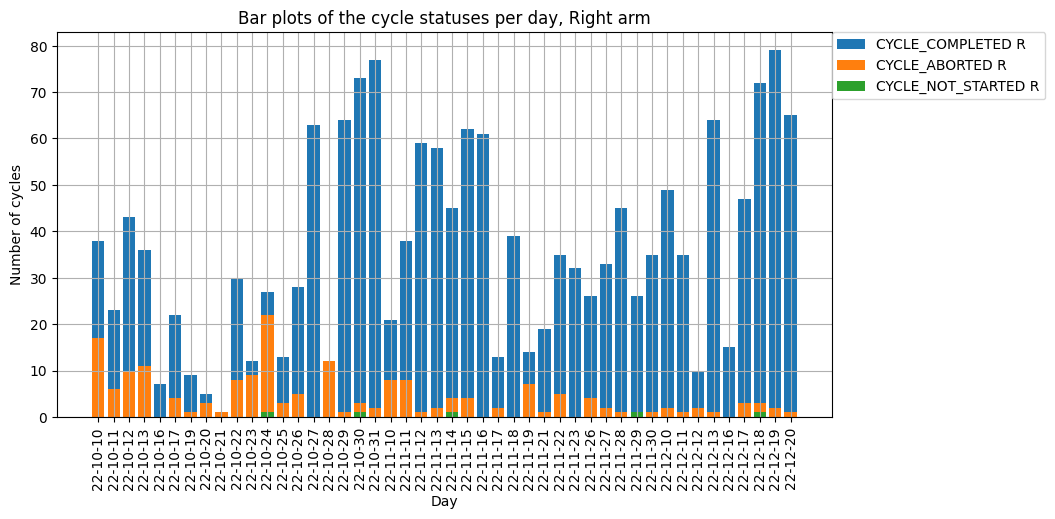

In [55]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_right[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day[2]))
plt.bar(statuses_per_day_right[0][ColumnsOutput.day], statuses_per_day_right[0]['count'], label = status_names[0] + ' R')
plt.bar(statuses_per_day_right[1][ColumnsOutput.day], statuses_per_day_right[1]['count'], label = status_names[1] + ' R')
plt.bar(statuses_per_day_right[2][ColumnsOutput.day], statuses_per_day_right[2]['count'], label = status_names[2] + ' R')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Right arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

In [56]:
# figure, ax = plt.subplots(figsize=(10, 5))
# print(len(statuses_per_day[0]))
# #ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
# print(len(statuses_per_day_right[2]), len(statuses_per_day_left[2]))

# for i in range(len(statuses_per_day)-1):
#     x = np.arange(len(days))
#     x1 = [i + 0.4 for i in x]
#     ax.bar(x, statuses_per_day_right[i]['count'], width = 0.4, label = str(statuses_per_day_right[i][ColumnsOutput.status].unique()))
#     ax.bar(x1, statuses_per_day_left[i]['count'], width = 0.4, label = str(statuses_per_day_left[i][ColumnsOutput.status].unique()))

# plt.grid(True)
# plt.show()

Index(['y-m-day', 'ddc_ev_timestamp', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')
    y-m-day    ddc_ev_timestamp ddc_mch_side  ddc_barcode                 first                   last             status
0  22-10-10 2022-10-10 00:02:50            L   9439703147        CURING_ON_STOP       CURING_OFF_START  CYCLE_NOT_STARTED
1  22-10-10 2022-10-10 00:02:50            R   9439703146        CURING_ON_STOP       CURING_OFF_START  CYCLE_NOT_STARTED
2  22-10-10 2022-10-10 00:02:52            L   9439703147  OP_SQUEEZE_OFF_START        CURING_OFF_STOP  CYCLE_NOT_STARTED
3  22-10-10 2022-10-10 00:02:52            R   9439703146  OP_SQUEEZE_OFF_START        CURING_OFF_STOP  CYCLE_NOT_STARTED
4  22-10-10 2022-10-10 00:02:54            L   9439703147   OP_SQUEEZE_OFF_STOP  OP_UNLOCK_PRESS_START  CYCLE_NOT_STARTED


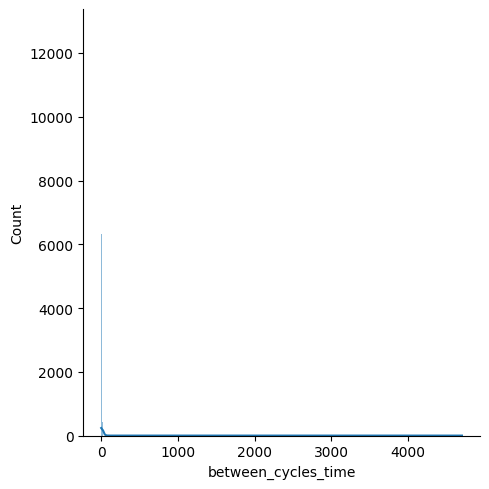

              status       mean  median         std  min     max
0      CYCLE_ABORTED  99.612723     2.0  451.904602  0.0  4703.0
1    CYCLE_COMPLETED   1.704451     1.0    8.899706  0.0   362.0
2  CYCLE_NOT_STARTED  35.291397     3.0  175.688801  0.0  1620.0
              status       mean  median         std  min     max
0      CYCLE_ABORTED  89.777315     3.0  401.197443  0.0  4504.0
1    CYCLE_COMPLETED   2.284738     1.0   31.197885  0.0  1258.0
2  CYCLE_NOT_STARTED  35.713960     4.0  175.964547  0.0  1620.0


<Axes: xlabel='status'>

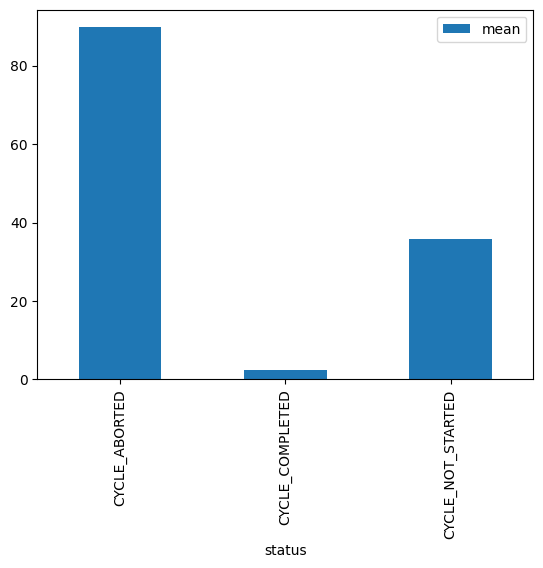

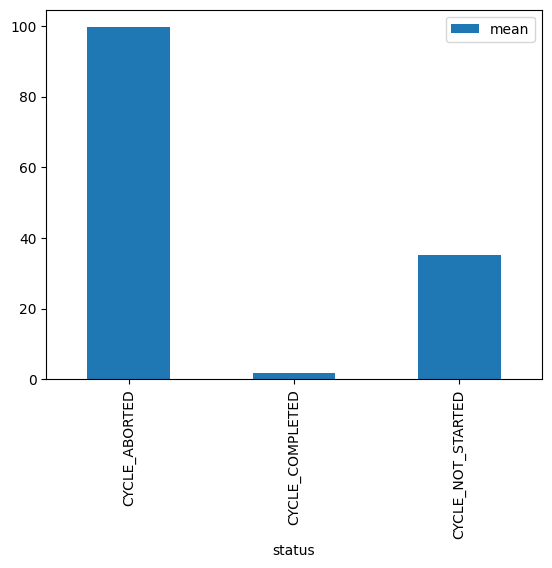

In [87]:
label_cycle_status_for_time = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.time, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status_for_time[ColumnsOutput.status] = False
print(label_cycle_status_for_time.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status_for_time[ColumnsOutput.status] = label_cycle_status_for_time.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status_for_time.value_counts(ColumnsOutput.status)
print(label_cycle_status_for_time.head())
plt.show()

label_cycle_status_for_time_left = label_cycle_status_for_time[label_cycle_status_for_time[ColumnsInput.machine_side] == 'L']
label_cycle_status_for_time_right = label_cycle_status_for_time[label_cycle_status_for_time[ColumnsInput.machine_side] == 'R']

label_cycle_status_for_time_left['between_cycles_time'] = label_cycle_status_for_time_left[ColumnsInput.time].diff().dt.total_seconds()
label_cycle_status_for_time_right['between_cycles_time'] = label_cycle_status_for_time_right[ColumnsInput.time].diff().dt.total_seconds()

label_cycle_status_for_time_left['between_cycles_time'] = label_cycle_status_for_time_left['between_cycles_time'].fillna(0)
label_cycle_status_for_time_right['between_cycles_time'] = label_cycle_status_for_time_right['between_cycles_time'].fillna(0)

z = np.abs(stats.zscore(label_cycle_status_for_time_right['between_cycles_time']))
label_cycle_status_for_time_right = label_cycle_status_for_time_right[(z < 1)]

z = np.abs(stats.zscore(label_cycle_status_for_time_left['between_cycles_time']))
label_cycle_status_for_time_left = label_cycle_status_for_time_left[(z < 1)]

sns.displot(label_cycle_status_for_time_right['between_cycles_time'], kde=True)
plt.show()

label_cycle_status_for_time_right_stats = label_cycle_status_for_time_right.groupby([ColumnsOutput.status])['between_cycles_time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
label_cycle_status_for_time_left_stats = label_cycle_status_for_time_left.groupby([ColumnsOutput.status])['between_cycles_time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

print(label_cycle_status_for_time_right_stats)
label_cycle_status_for_time_left_stats.plot(kind='bar', x=ColumnsOutput.status, y='mean')
print(label_cycle_status_for_time_left_stats)
label_cycle_status_for_time_right_stats.plot(kind='bar', x=ColumnsOutput.status, y='mean')



## Getting all previous indices per day fro the machines

In [58]:

len(days)



46

In [59]:
# variables = [mach_tyre_per_day, mach_tyre_per_day_per_left, mach_tyre_per_day_per_right ,working_time_per_day, working_time_per_day_per_left, 
#              working_time_per_day_per_right, statuses_per_day_left[0], statuses_per_day_left[1], statuses_per_day_left[2], 
#              statuses_per_day_right[0], statuses_per_day_right[1], statuses_per_day_right[2], statuses_per_day[0], statuses_per_day[1], 
#              statuses_per_day[2]] # TODO issue on index
tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode]
tyre_per_day_left = mach_tyre_per_day_per_left[ColumnsInput.barcode]


tyre_per_day_right = mach_tyre_per_day_per_right[ColumnsInput.barcode]
work_time_per_day = working_time_per_day['work_time']
work_time_per_day_left = working_time_per_day_per_left['work_time']
work_time_per_day_right = working_time_per_day_per_right['work_time']
status_per_day_left_1 = cycle_statuses_per_day_left['CYCLE_COMPLETED']
status_per_day_left_2 =cycle_statuses_per_day_left['CYCLE_ABORTED']
status_per_day_left_3 = cycle_statuses_per_day_left['CYCLE_NOT_STARTED']
status_per_day_right_1 = cycle_statuses_per_day_right['CYCLE_COMPLETED']
status_per_day_right_2 = cycle_statuses_per_day_right['CYCLE_ABORTED']
status_per_day_right_3 = cycle_statuses_per_day_right['CYCLE_NOT_STARTED']
status_per_day_1 = statuses_per_day[0]['count']
status_per_day_2 = statuses_per_day[1]['count']
status_per_day_3 = statuses_per_day[2]['count']

# colums_name = ['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right','completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs']

mach_processed_df = pd.DataFrame()
mach_processed_df['day'] = days
mach_processed_df['tyre_per_day'] = tyre_per_day
mach_processed_df['tyre_per_day_left'] = tyre_per_day_left
mach_processed_df['tyre_per_day_right'] = tyre_per_day_right
mach_processed_df['work_time_per_day'] = work_time_per_day
mach_processed_df['work_time_per_day_left'] = work_time_per_day_left
mach_processed_df['work_time_per_day_right'] = work_time_per_day_right
mach_processed_df['completed_jobs_left'] = status_per_day_left_1
mach_processed_df['aborted_jobs_left'] = status_per_day_left_2
mach_processed_df['not_started_jobs_left'] = status_per_day_left_3
mach_processed_df['completed_jobs_right'] = status_per_day_right_1
mach_processed_df['aborted_jobs_right'] = status_per_day_right_2
mach_processed_df['not_started_jobs_right'] = status_per_day_right_3
mach_processed_df['completed_jobs'] = status_per_day_1
mach_processed_df['aborted_jobs'] = status_per_day_2
mach_processed_df['not_started_jobs'] = status_per_day_3

mach_processed_df.sort_values(by=['day'], inplace = True)
#mach_processed_df.fillna(0, inplace = True)
mach_processed_df


,day,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
0,22-10-10,110,55,55,85721.0,85721.0,85721.0,21,33,1,38,17,0,59,50,1
1,22-10-11,58,29,29,63002.0,62999.0,63002.0,13,15,1,23,6,0,36,21,1
2,22-10-12,104,51,53,85915.0,85915.0,85915.0,26,25,0,43,10,0,69,35,0
3,22-10-13,94,47,47,57824.0,57821.0,57824.0,32,15,0,36,11,0,68,26,0
4,22-10-16,14,7,7,12021.0,12019.0,12021.0,3,4,0,7,0,0,10,4,0
5,22-10-17,52,26,26,38022.0,38019.0,38022.0,14,12,0,22,4,0,36,16,0
6,22-10-19,20,10,10,13076.0,13076.0,13076.0,5,5,0,9,1,0,14,6,0
7,22-10-20,23,15,8,26516.0,26514.0,26516.0,8,7,0,5,3,0,13,10,0
8,22-10-21,4,2,2,61335.0,61335.0,61335.0,1,1,0,1,1,0,2,2,0
9,22-10-22,76,38,38,85691.0,85688.0,85691.0,13,24,1,30,8,0,43,32,1


<Axes: >

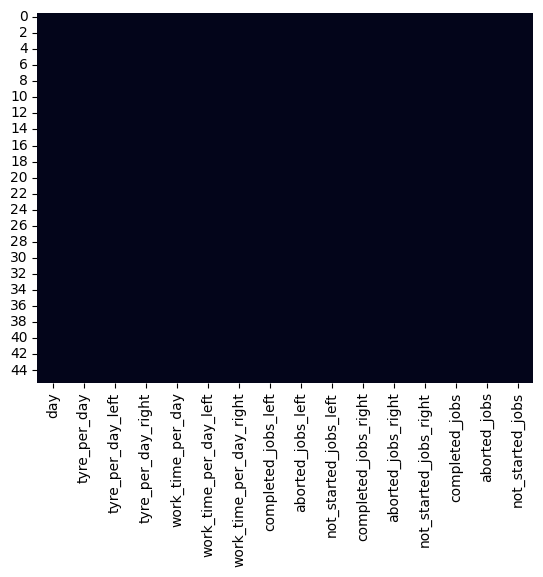

In [60]:
sns.heatmap(mach_processed_df.isna(), cbar=False)

In [61]:
mach_processed_df = mach_processed_df.fillna(0)

### Correlation between the tyres produced and the completed cycles

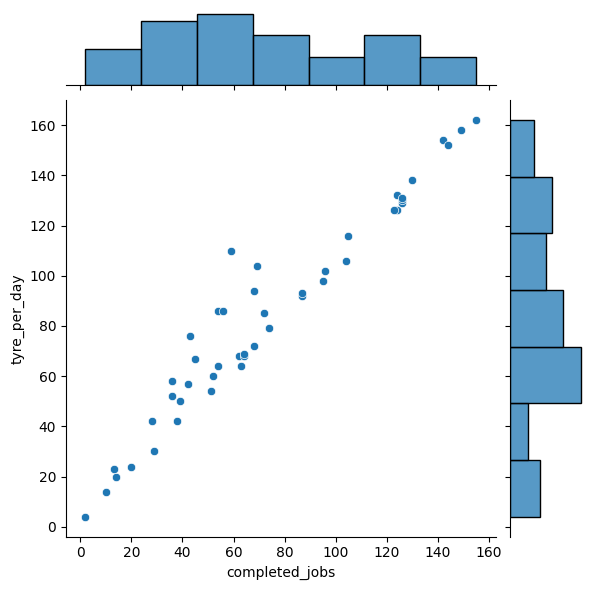

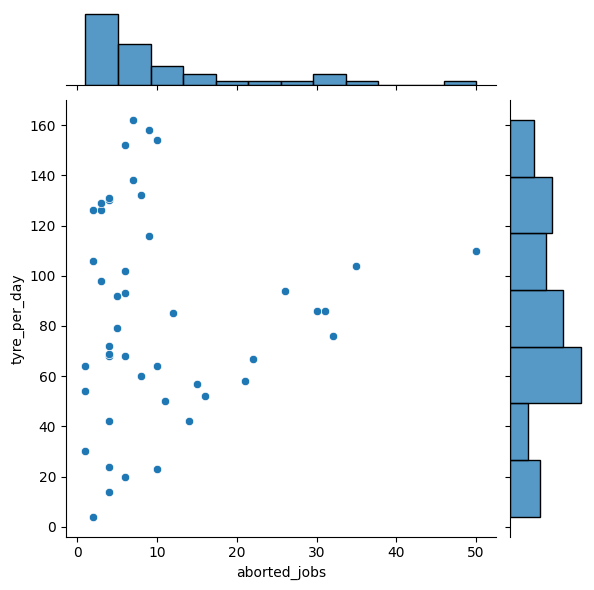

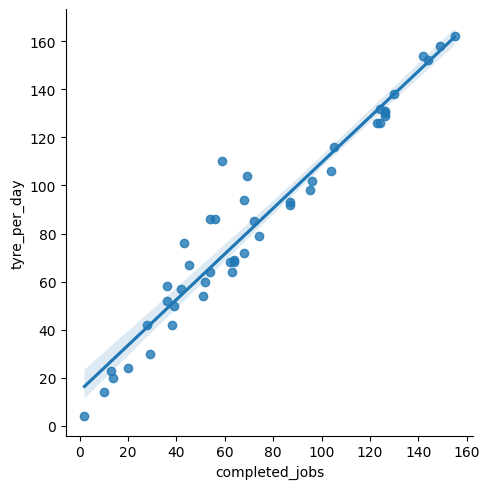

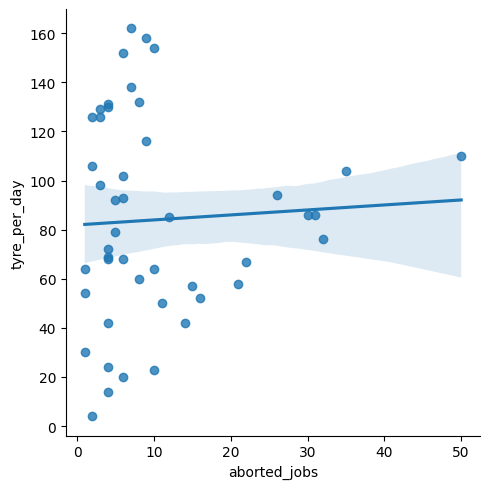

In [62]:
sns.jointplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df)

### Correlation between the working time and the completed cycle

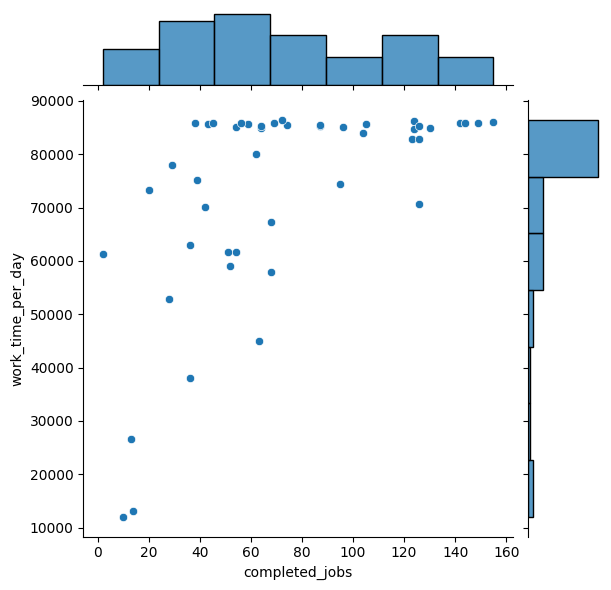

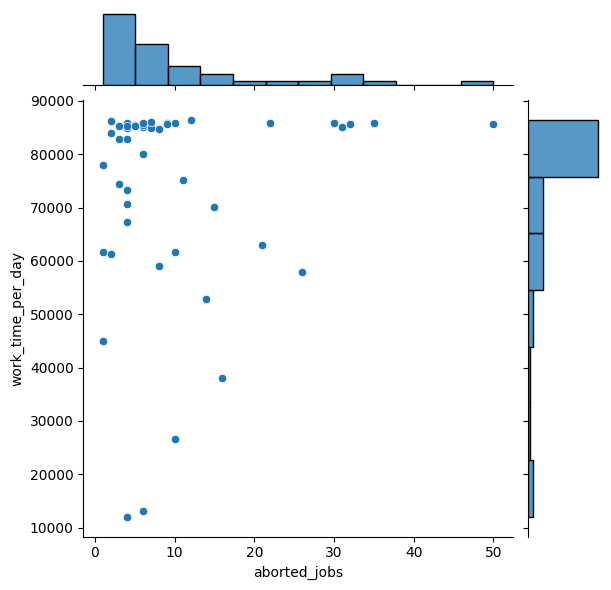

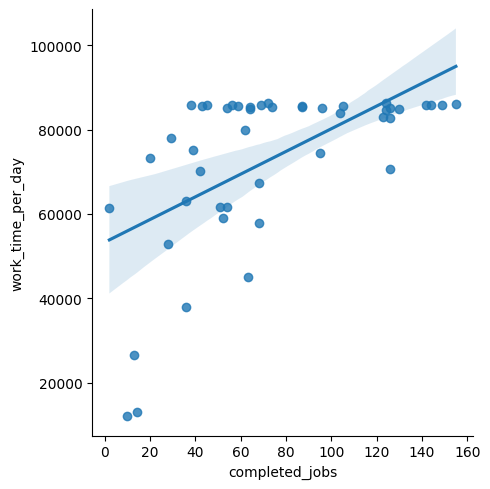

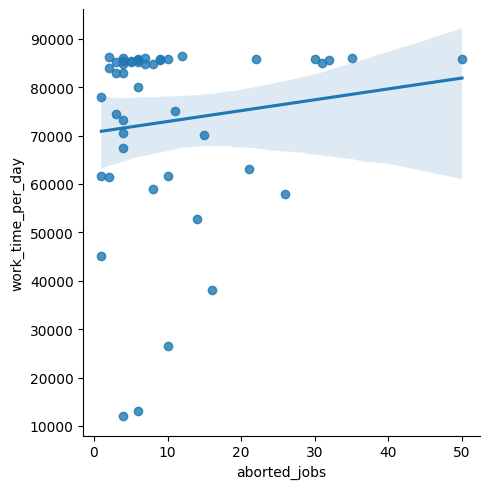

In [63]:
sns.jointplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns. jointplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df)

### Correlation per sides

Completed jobs correlation with the tyre per day by side

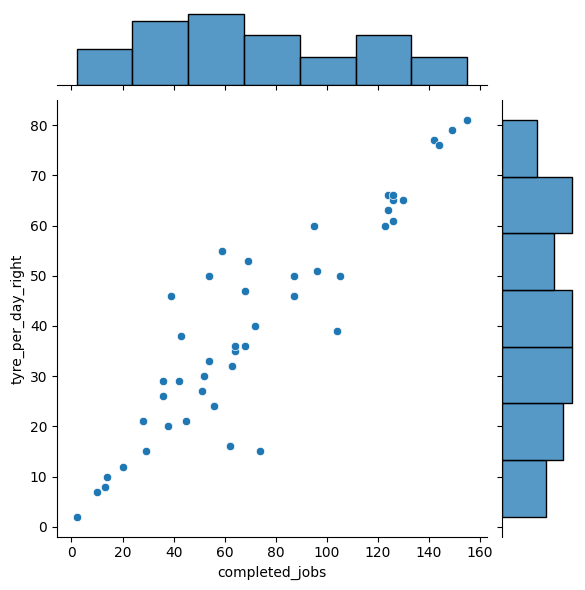

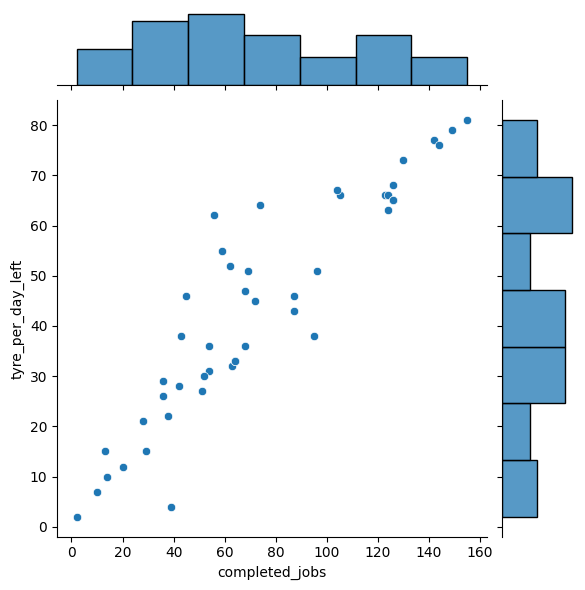

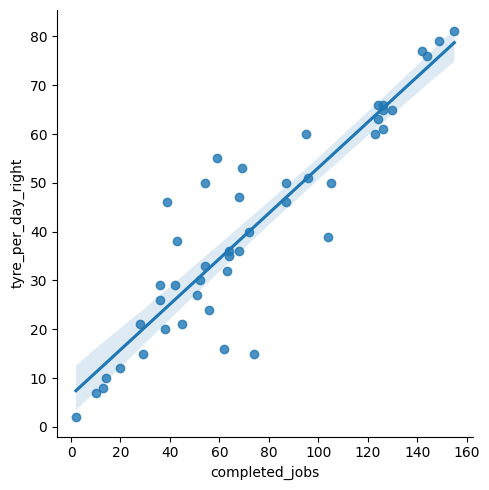

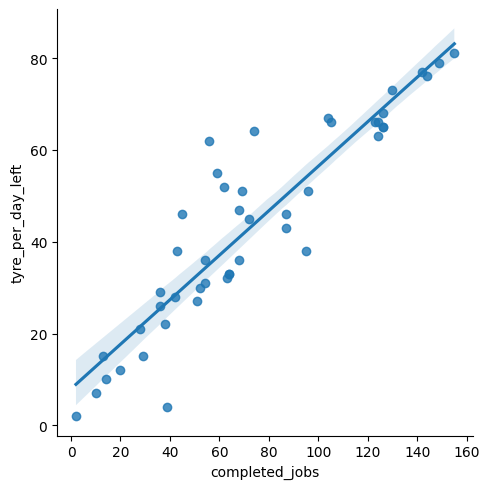

In [64]:
sns.jointplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df)

Aborted jobs correlation with the tyre per day by side

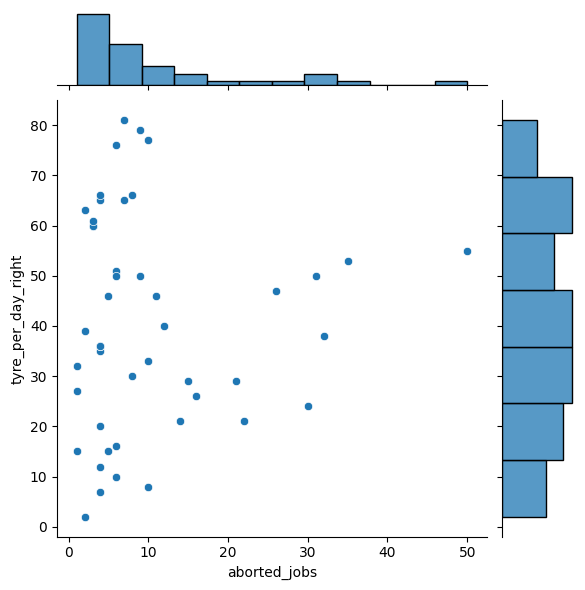

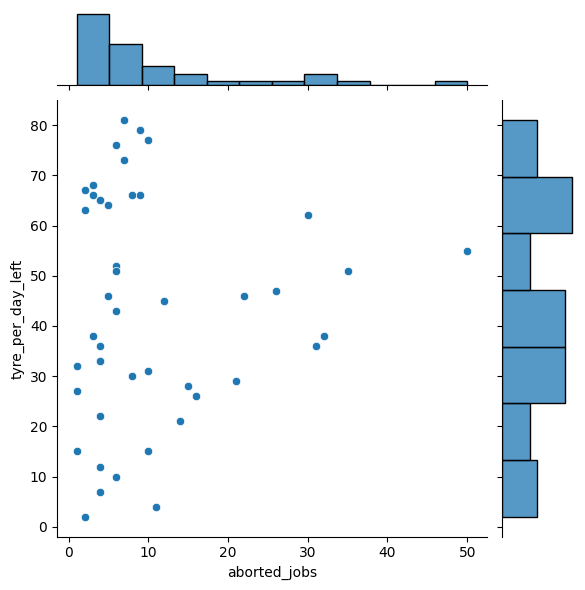

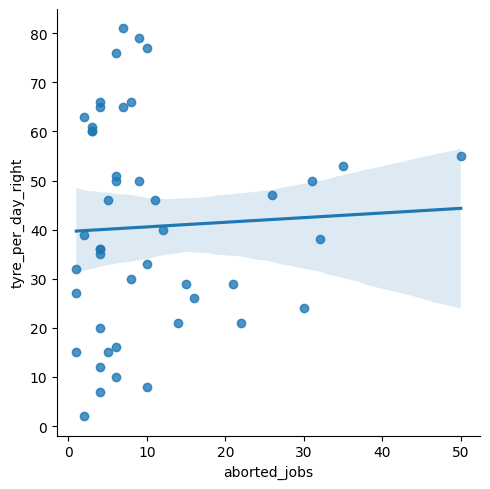

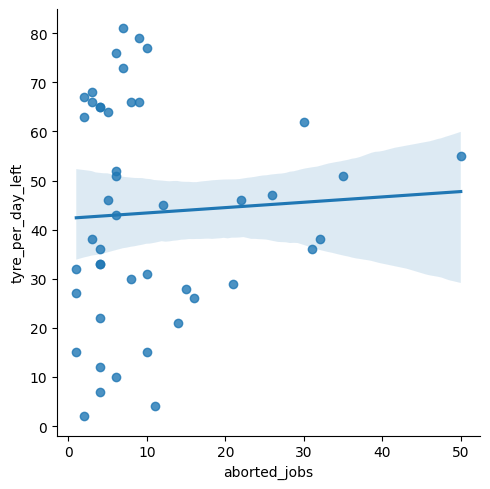

In [65]:
sns.jointplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df)

Jobs correlation with the tyre per day by side


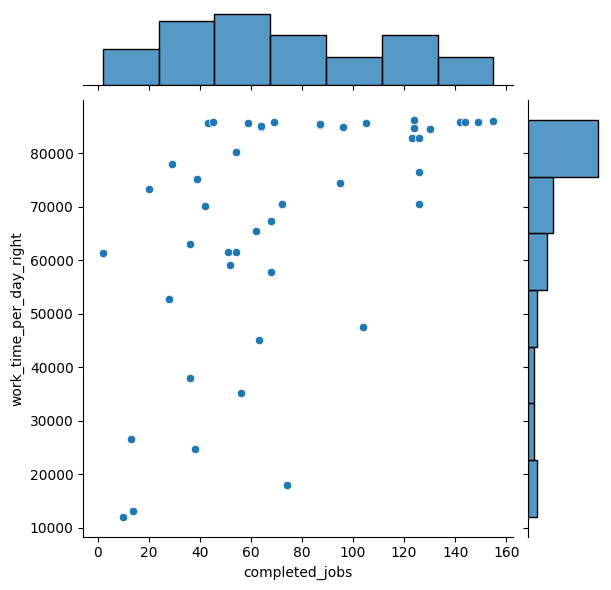

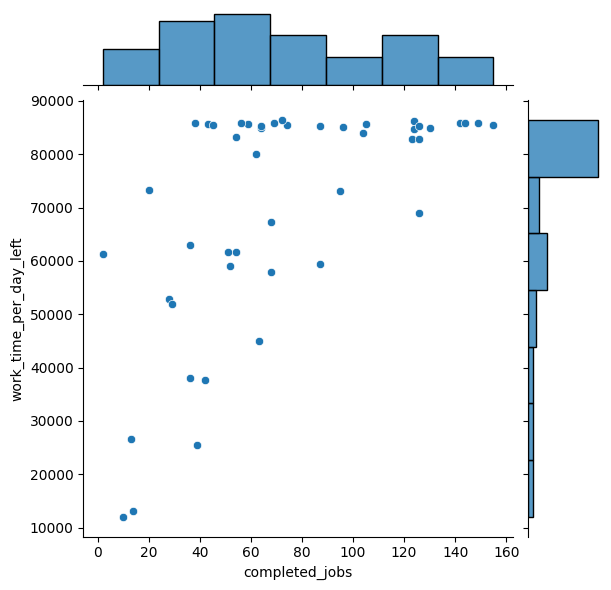

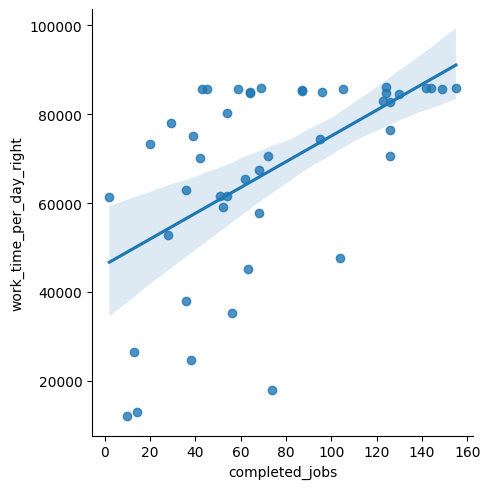

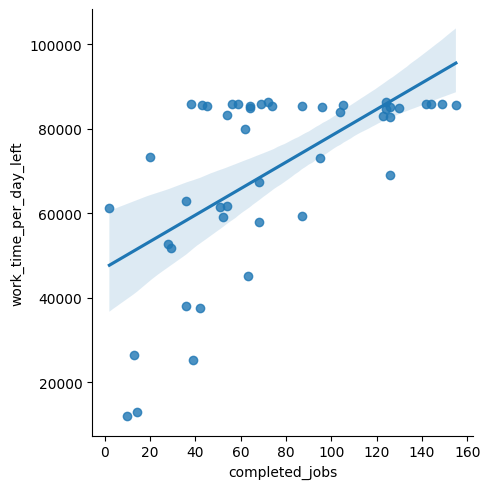

In [66]:
sns.jointplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df)

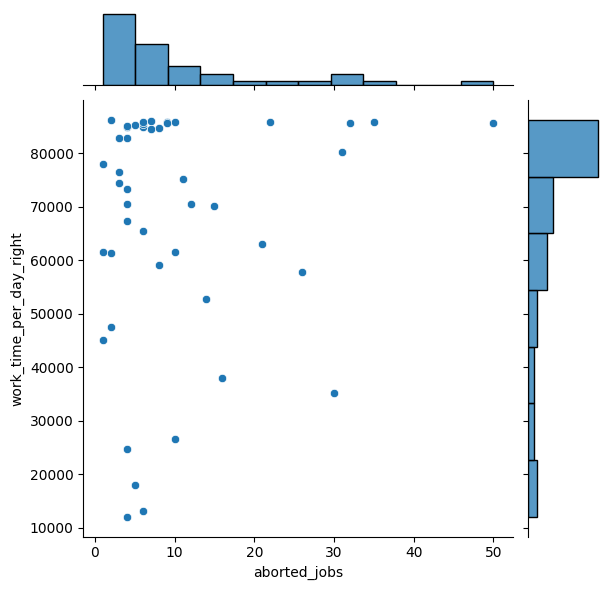

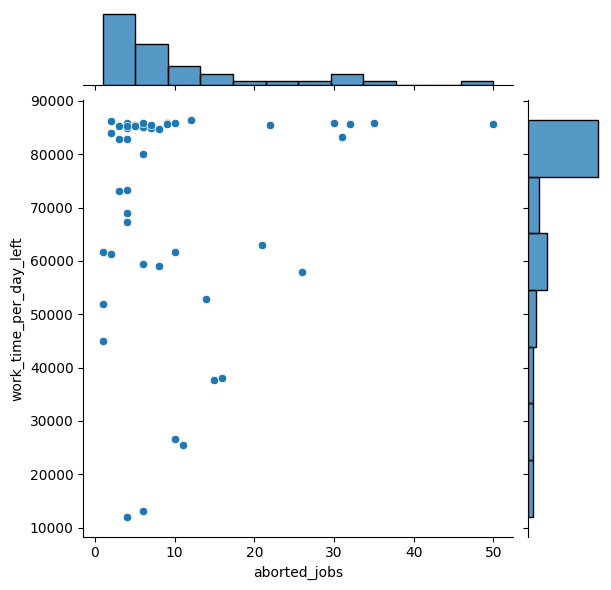

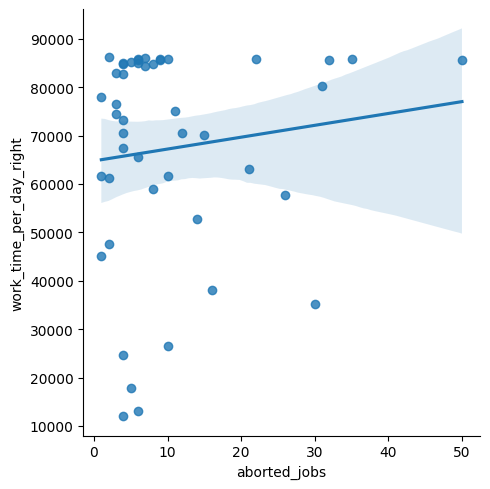

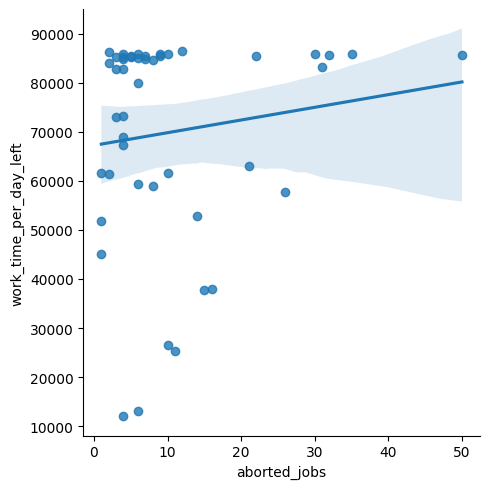

In [67]:
sns.jointplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df)

#### Ideally it should be better to check by arm instead of the enitire miachine at the moment, and apply a regression method to understand the correlation between the barcode processed and the completed cycles

#### fist check the right side

In [68]:
# the data that are more correlated are the tyre per day and the completed jobs.
print(mach_processed_df.columns)

check_corr = mach_processed_df.drop(['day'], axis=1).corr()
check_corr

Index(['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right', 'completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs'], dtype='object')


,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
tyre_per_day,1.000000,0.946647,0.942546,0.624535,0.660692,0.593658,0.902882,0.076186,0.274014,0.925144,0.009594,0.243724,0.965872,0.053112,0.304465
tyre_per_day_left,0.946647,1.000000,0.784595,0.624838,0.719358,0.448536,0.950640,0.093351,0.246900,0.775326,-0.016608,0.206623,0.913997,0.052823,0.267954
tyre_per_day_right,0.942546,0.784595,1.000000,0.553797,0.525375,0.677154,0.751564,0.049802,0.271224,0.976130,0.035674,0.254701,0.910734,0.047422,0.307981
work_time_per_day,0.624535,0.624838,0.553797,1.000000,0.883923,0.714129,0.584180,0.087132,0.205829,0.510962,0.157885,0.141801,0.579543,0.124216,0.208408
work_time_per_day_left,0.660692,0.719358,0.525375,0.883923,1.000000,0.589567,0.659751,0.140347,0.264517,0.496316,0.093108,0.173599,0.612684,0.130432,0.263586
work_time_per_day_right,0.593658,0.448536,0.677154,0.714129,0.589567,1.000000,0.407796,0.091461,0.288091,0.635777,0.139904,0.200338,0.549143,0.119230,0.292618
completed_jobs_left,0.902882,0.950640,0.751564,0.584180,0.659751,0.407796,1.000000,-0.219678,0.142927,0.790056,-0.238325,0.218408,0.948230,-0.244160,0.203691
aborted_jobs_left,0.076186,0.093351,0.049802,0.087132,0.140347,0.091461,-0.219678,1.000000,0.263751,-0.104141,0.720665,-0.077995,-0.172344,0.954086,0.139368
not_started_jobs_left,0.274014,0.246900,0.271224,0.205829,0.264517,0.288091,0.142927,0.263751,1.000000,0.248647,0.058297,0.459179,0.205841,0.194706,0.899570
completed_jobs_right,0.925144,0.775326,0.976130,0.510962,0.496316,0.635777,0.790056,-0.104141,0.248647,1.000000,-0.181786,0.197374,0.943845,-0.145475,0.264583


In [69]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

def svr_regression(x,y):
    print("Model: SVR")
    model = SVR(C=1.0, epsilon=0.2).fit(x, y)
    return model
    
def lin_regr(x, y):
    print("Model: Linear Regression")
    model = LinearRegression().fit(x, y)
    return model 

def grad_boost(x, y):
    print("Model: Gradient Boosting")
    model = GradientBoostingRegressor(random_state=0).fit(x, y)
    return model

def evaluations(x,y, f, desc = None):
    
    if desc is not None:
        print(desc)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    scaler = preprocessing.RobustScaler()
    X_train = scaler.fit_transform(X_train.values.reshape(-1,1))
    y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
    X_test = scaler.fit_transform(X_test.values.reshape(-1,1))
    y_test = scaler.fit_transform(y_test.values.reshape(-1,1))
    
    model = f(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print(f"Model score: {train_score}")
    model_prediction = model.predict(X_test)
    accuracy_score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, model_prediction)
    r2 = r2_score(y_test, model_prediction)
    print("Metrics are:\n Accuracy: {}\n MSE: {} \n R2: {}\n\n".format(accuracy_score, mse, r2))
    
    return model

In [70]:
#split data into train and test
from sklearn.model_selection import train_test_split


right_x = mach_processed_df['tyre_per_day_right']
right_y = mach_processed_df['completed_jobs_right']



left_x = mach_processed_df['tyre_per_day_left']
left_y = mach_processed_df['completed_jobs_left']



model = evaluations(right_x, right_y, lin_regr)
model = evaluations(right_x, right_y, svr_regression)
model = evaluations(right_x, right_y, grad_boost)

model = evaluations(left_x, left_y, lin_regr)
model = evaluations(left_x, left_y, svr_regression)
model = evaluations(left_x, left_y, grad_boost)



Model: Linear Regression
Model score: 0.930614496816238
Metrics are:
 Accuracy: 0.9072386089882412
 MSE: 0.09510483523559436 
 R2: 0.9072386089882412


Model: SVR
Model score: 0.9345596203470301
Metrics are:
 Accuracy: 0.4450362838817459
 MSE: 0.5689838434663962 
 R2: 0.4450362838817459


Model: Gradient Boosting
Model score: 0.9769784491231952
Metrics are:
 Accuracy: 0.7870915949331507
 MSE: 0.21828714040725297 
 R2: 0.7870915949331507


Model: Linear Regression
Model score: 0.8598681210385531
Metrics are:
 Accuracy: 0.9465872716423511
 MSE: 0.014852687159550185 
 R2: 0.9465872716423511


Model: SVR
Model score: 0.8695970553043106
Metrics are:
 Accuracy: 0.9586426680404369
 MSE: 0.011500395734064655 
 R2: 0.9586426680404369


Model: Gradient Boosting
Model score: 0.9592404784206956
Metrics are:
 Accuracy: 0.851091981738565
 MSE: 0.04140743749273317 
 R2: 0.851091981738565




### On entire machine


In [71]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['completed_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.9033906450371927
Metrics are:
 Accuracy: 0.9104676248343357
 MSE: 0.07279512891434212 
 R2: 0.9104676248343357


Model: SVR
Model score: 0.9003552791241871
Metrics are:
 Accuracy: 0.8177640272831272
 MSE: 0.14816864963326445 
 R2: 0.8177640272831272


Model: Gradient Boosting
Model score: 0.9975988181340175
Metrics are:
 Accuracy: 0.8922097601425035
 MSE: 0.08763985532178198 
 R2: 0.8922097601425035




### evaluate the correlation between the aborted jobs and the tyre produced

In [72]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['aborted_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.012000394229678135
Metrics are:
 Accuracy: -0.06394671117859718
 MSE: 2.115562470300199 
 R2: -0.06394671117859718


Model: SVR
Model score: -0.0603111759345174
Metrics are:
 Accuracy: -0.17909055929107898
 MSE: 2.344515669923204 
 R2: -0.17909055929107898


Model: Gradient Boosting
Model score: 0.9757083386250708
Metrics are:
 Accuracy: -0.15026607013748383
 MSE: 2.287200762288996 
 R2: -0.15026607013748383


